<a href="https://colab.research.google.com/github/miraclehimself/Advanced_ML/blob/main/Model_Ensembles_week_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AML 22-23 W7 Ensemble Regression

### Packages

In [ ]:
!pip install --upgrade scikit-learn -q --user
# need to restart kernel, if latest versions not already installed

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# https://seaborn.pydata.org/tutorial/aesthetics.html
sns.set(
    style='ticks',
    context='talk',
    font_scale=0.8,
    rc={'figure.figsize': (8,6)}
)

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, ParameterGrid

In [ ]:
from sklearn.metrics import mean_squared_error
from functools import partial
rmse = partial(mean_squared_error, squared=False)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
# from category_encoders import TargetEncoder

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor

In [ ]:
!pip install -q shap
import shap
shap.initjs()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 21.1 MB/s eta 0:00:00


## Dataset

In [ ]:
rides_full = pd.read_csv(
    'https://raw.githubusercontent.com/christophM/interpretable-ml-book/master/data/bike.csv'
)

In [ ]:
rides_full.head(1)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0


In [ ]:
rides_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   season           731 non-null    object 
 1   yr               731 non-null    int64  
 2   mnth             731 non-null    object 
 3   holiday          731 non-null    object 
 4   weekday          731 non-null    object 
 5   workingday       731 non-null    object 
 6   weathersit       731 non-null    object 
 7   temp             731 non-null    float64
 8   hum              731 non-null    float64
 9   windspeed        731 non-null    float64
 10  cnt              731 non-null    int64  
 11  days_since_2011  731 non-null    int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 68.7+ KB


In [ ]:
rides = rides_full[
    [ 'season', 'workingday', 'temp', 'hum', 'windspeed', 'days_since_2011', 'cnt' ]
].rename(columns=dict(days_since_2011='days_elapsed', cnt='rides_count'))

In [ ]:
rides.head()

,season,workingday,temp,hum,windspeed,days_elapsed,rides_count
0,WINTER,NO WORKING DAY,8.175849,80.5833,10.749882,0,985
1,WINTER,NO WORKING DAY,9.083466,69.6087,16.652113,1,801
2,WINTER,WORKING DAY,1.229108,43.7273,16.636703,2,1349
3,WINTER,WORKING DAY,1.400000,59.0435,10.739832,3,1562
4,WINTER,WORKING DAY,2.666979,43.6957,12.522300,4,1600


In [ ]:
X, y = rides.drop(columns='rides_count'), rides['rides_count']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4, random_state=0)

## Reusable Pre-Processing and Model Fitting Pipelines

In [ ]:
def create_def_preprocessing_pipe(X):
    """creates a default preprocessing pipeline for numeric and categorical data
    using simple imputers, scalers, and encoders. It relies on latest versions
    of sklearn so as to produce pandas outputs.

    X: the dataset with the features (needed for feature names)

    returns the Pipeline object
    """

    numeric_features = X.select_dtypes(exclude='object').columns.tolist()
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            # ('poly', PolynomialFeatures(include_bias=False))
        ]
    ).set_output(transform='pandas')

    categorical_features = X.select_dtypes(include='object').columns.tolist()
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='if_binary')),
        ]
    ).set_output(transform='pandas')

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    ).set_output(transform="pandas")

    return preprocessor

In [ ]:
def create_regr_pipe(est, X):
    """ """
    regr_pipe = Pipeline(
        steps=[
            ("pp", create_def_preprocessing_pipe(X)),
            ("regr", est)
        ]
    ).set_output(transform="pandas")

    return regr_pipe

## Model Fitting

In [ ]:
gbr = create_regr_pipe(GradientBoostingRegressor(), X_train)

In [ ]:
gbr.fit(X_train, y_train)

Pipeline(steps=[('pp',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'hum', 'windspeed',
                                                   'days_elapsed']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['season', 'workingday'])],
                                   verbose_feature_names_out=False)),
                ('regr', GradientBoostingRegressor())])

In [ ]:
scores = cross_val_score(gbr, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')
scores.mean()*-1, scores.std()

(666.7060050791733, 97.4491666538853)

In [ ]:
rfr = create_regr_pipe(RandomForestRegressor(), X_train)
# lr = create_regr_pipe(Ridge(), X_train)
# lr = create_regr_pipe(KNeighborsRegressor(21), X)
hgb = create_regr_pipe(HistGradientBoostingRegressor(), X_train)

In [ ]:
ensembled = [ gbr, rfr, hgb ]

In [ ]:
for est in ensembled:
    est.fit(X_train, y_train)

In [ ]:
ensemble = VotingRegressor(
    [
        ("gb", gbr),
        ("rf", rfr),
        ("hbg", hgb)
    ]
)
ensemble.fit(X_train, y_train)

VotingRegressor(estimators=[('gb',
                             Pipeline(steps=[('pp',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['temp',
                                                                                'hum',
                                                                                'windspeed',
                                                                                'days_elapsed']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(d...
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['temp',
                                                                                'hum',
                                                                                'windspeed',
                                                                                'days_elapsed']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='if_binary',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['season',
                                                                                'workingday'])],
                                                                verbose_feature_names_out=False)),
                                             ('regr',
                                              HistGradientBoostingRegressor())]))])

In [ ]:
all_regr = ensembled + [ ensemble ]

In [ ]:
for est in all_regr:
    scores = cross_val_score(est, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    print(scores.mean()*-1, scores.std())

673.1912389217896 99.42867799665221
708.0816457937195 130.89291441436333
691.3358490491552 101.43600684552291
669.7145717492857 107.37296867089118


## Inspection of Model Output

In [ ]:
# quickly adapted from the sklearn documentation
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html
xt = X.head(20)
pred1 = gbr.predict(xt)
pred2 = rfr.predict(xt)
pred3 = hgb.predict(xt)
pred4 = ensemble.predict(xt)

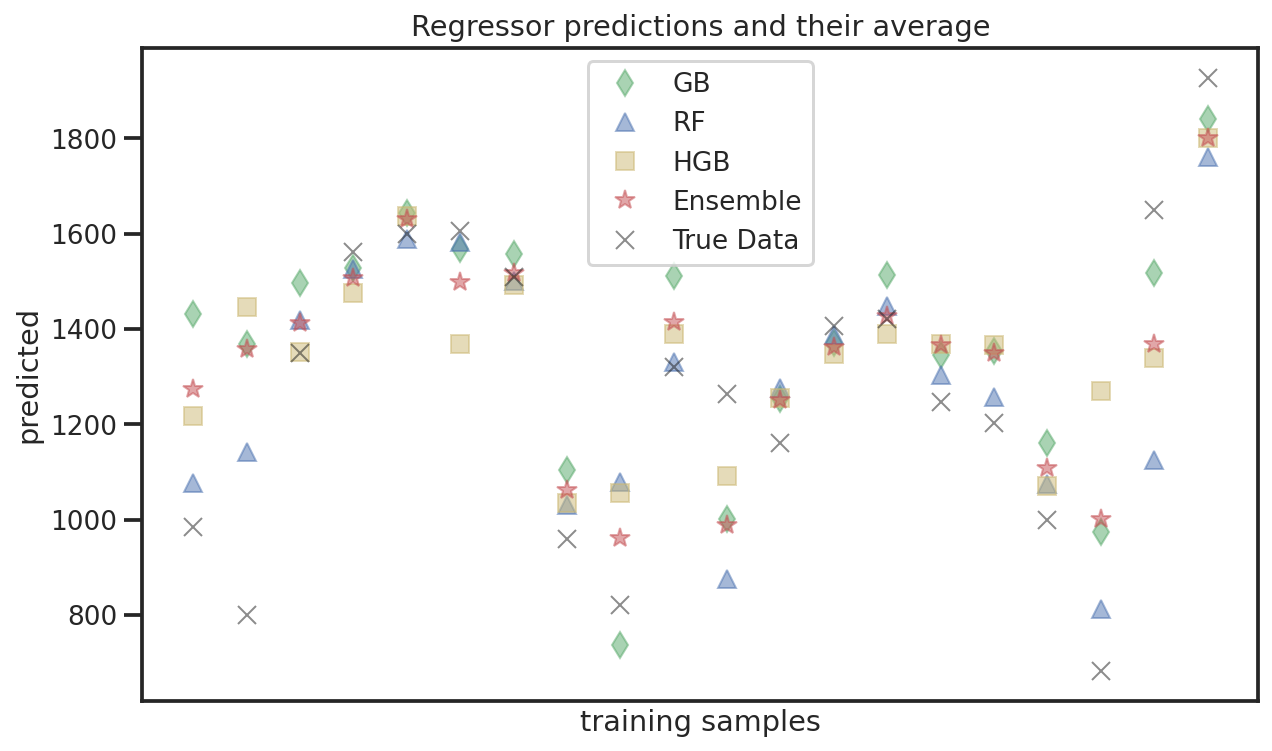

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(pred1, "gd", alpha=0.5, label="GB")
plt.plot(pred2, "b^", alpha=0.5, label="RF")
plt.plot(pred3, "ys", alpha=0.5, label="HGB")
plt.plot(pred4, "r*", alpha=0.5, ms=10, label="Ensemble")
plt.plot(y.head(20), "kx", alpha=0.5, label="True Data")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Regressor predictions and their average")

plt.show()

In [ ]:
instance = X.head(1)
(gbr.predict(instance), rfr.predict(instance), hgb.predict(instance), ensemble.predict(instance))

(array([1432.0883803]),
 array([1077.11]),
 array([1217.50652609]),
 array([1274.72830213]))